In [ ]:
# Projeto Visão computacional - reconhecimento da íris 
# objetivo:
# 1. Criar um modelo de treinamento usando a base de dados fornecida - melhorar a qualidade das imagens
# 2. obter a matriz de confusão do modelo 
# 3. analisar os resultados

In [ ]:
!git clone https://github.com/lucianosilva-github/G6_iris_recognition.git

In [ ]:
# clone do repositorio em que estao as imagens originais - sem nenhum tipo de tratamento 
!git clone https://github.com/lucianosilva-github/images.git

In [ ]:
# images_train -> pasta com poucas imagens. Apenas utilizadas pra treinamento inicial do programa 
# imagens_train_processadas -> pasta com imagens processadas 

In [1]:
import cv2
import cv2 as cv
import os
from os import walk
import numpy as np
from matplotlib import pyplot as plt
import pywt

In [2]:
# Various recommendations exist for starting values of these parameters,
# and the meaning may differ between implementations. 
# Generally a radius of 0.5 to 2 pixels and an amount of 50–150% is recommended.

# fonte: https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking
def sharpen_image(img, kernel_size=(5, 5), sigma=1.5, amount=2.0, threshold=0):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)

    # formula para melhorar a nitidez da imagem 
    sharpened = float(amount + 1) * img - float(amount) * blurred

    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)

    if threshold > 0:
        low_contrast_mask = np.absolute(img - blurred) < threshold
        np.copyto(sharpened, img, where=low_contrast_mask)

    return sharpened

In [3]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

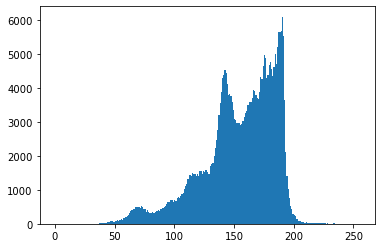

In [4]:
# plotar o histograma da imagem

# EXPLICAR SOBRE ESSA IDEIA DO HISTOGRAMA BIMODAL - DOIS PICOS

image = cv2.imread('images/0000/0000_008.bmp')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.hist(img.ravel(),bins=255,range=[0,255]) # da pra ver melhor os dois picos b-> range=[100,225]
plt.show()

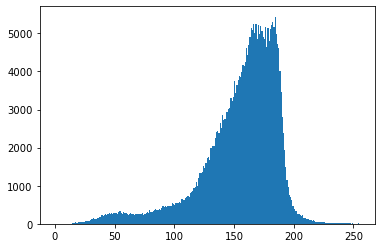

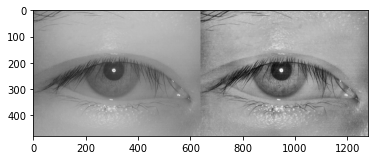

In [5]:
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img)

# TRANSFORMAÇAO DO HISTOGRAMA PARA UM DE APENAS UM PICO
plt.hist(cl_img.ravel(),bins=255,range=[0,255]) # da pra ver melhor os dois picos -> range=[100,225]
plt.show()

# imagem tradata -> colocar titulos (????)
plt.imshow(np.hstack((img, cl_img)), 'gray')
plt.show()

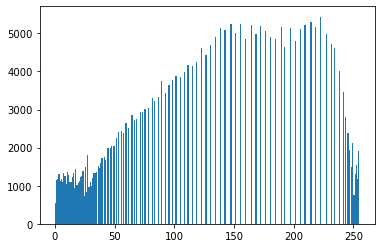

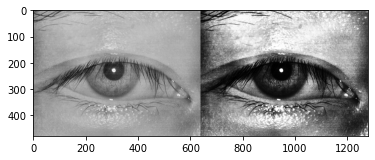

In [6]:
# equalizacao da clahe - EXPLICAR QUE EQUALIZAMOS MAS NAO VIMOS MUDANCA, PQ? 
img_equ = cv2.equalizeHist(cl_img)

plt.hist(img_equ.ravel(),bins=255,range=[0,255]) # da pra ver melhor os dois picos b-> range=[100,225]
plt.show()

# imagem tradata -> colocar titulos (????)
plt.imshow(np.hstack((cl_img, img_equ)), 'gray')
plt.show()

# colocar funcao de ajustar o brilho -> apply_brightness_contrast()

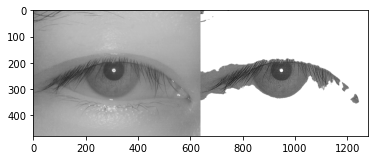

In [7]:
# IDEIA DE FOCAR SÓ NA IRIS - TENTAR MELHORAR ELA 
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

img_s = cv2.filter2D(img, -1, kernel)

T, img_bin = cv.threshold(img_s.astype('uint8'),127,255,cv.THRESH_BINARY)
# T , img_bin = cv.threshold(img_s.astype('uint8'),0,255,cv.THRESH_BINARY)
img_bin = cv.GaussianBlur(img_bin,(11,11),50)
new_img = img_s.copy()
rows, cols = new_img.shape

for l in range(rows):
    for c in range(cols):
        if img_bin[l][c] > T:
            new_img[l][c] = 255
            
plt.imshow(np.hstack((img, new_img)), 'gray')
plt.show()

In [8]:
def percorre_pastas(num_pasta):
    for (dirpath, dirnames, filenames) in walk("images/00{}".format(num_pasta)):
        for e in filenames:
            image = cv.imread("images/00{0}/{1}".format(num_pasta, e))
            img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # qual a magia que essa funcao faz?
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl_img = clahe.apply(img)

            directory ="images_processadas/images_processadas_{0}/00{0}/".format(num_pasta)

            if not os.path.exists(directory):
                os.makedirs(directory)

            filename = "images_processadas/images_processadas_{0}/00{0}/{1}".format(num_pasta, e)
            
            cv.imwrite(filename, cl_img)

In [9]:
# processamento para varias imagens
n_pastas = 15
for i in range(0, n_pastas):
    if i < 10:
        n ="0{}".format(i)
    else :
        n = i
        
    percorre_pastas(n)

In [12]:
# treinar em cada pasta 
import G6_iris_recognition
            
for i in range(0, n_pastas):
    
    if i < 10:
        n ="0{}".format(i)
    
    else :
        if i == 12: 
            i = 13
        n = i
        
    valid_images = G6_iris_recognition.iris_model_train("./images_processadas/images_processadas_{0}".format(n),"model.pickle")
    
    directory ="valid_images/00{0}/".format(n)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    for image in valid_images[1]:
        name = image.split('\\')[2]
                
        filename = "valid_images/00{0}/{1}".format(n, name)
        image = cv.imread("images_processadas/images_processadas_{0}/00{0}/{1}".format(n, name))
        
        cv.imwrite(filename, image)

directory_list ['./images_processadas/images_processadas_00\\0000']
name 0000
path_to_image ./images_processadas/images_processadas_00\0000\0000_000.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_001.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_002.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_003.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_004.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_00\0000\0000_005.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_00\0000\0000_006.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_007.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_008.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_009.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_010.bmp
path_to_image ./images_processadas/images_processadas

path_to_image ./images_processadas/images_processadas_03\0003\0003_010.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_03\0003\0003_011.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_012.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_013.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_014.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_015.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_016.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_017.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_018.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_019.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not en

rectangle expression1
path_to_image ./images_processadas/images_processadas_06\0006\0006_003.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_004.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_005.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_06\0006\0006_006.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_007.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_008.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_009.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_010.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_011.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_012.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_013.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_014.bmp
path_to_image ./images_processadas/images_processadas_06

name 0010
path_to_image ./images_processadas/images_processadas_10\0010\0010_000.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_001.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_002.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_003.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_004.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_10\0010\0010_005.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_006.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_007.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_008.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_10\0010\0010_009.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_010.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_011.bmp
path_to_image ./images_processadas/images_proc

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_002.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_003.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_004.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_005.bmp
path_to_image ./images_processadas/images_processadas_13\0013\0013_006.bmp
locate expression 1 index 640 is out of bounds for axis 1

In [ ]:
# tratar as imagens que NAO deram certo -> o que fazer ?


In [16]:
# agora chegou a hora da verdade. Apos selecionadas as imagens que funcionam para o nosso modelo vamos treinar apenas elas 
valid_images = G6_iris_recognition.iris_model_train("./valid_images","model.pickle")


directory_list ['./valid_images\\0000', './valid_images\\0001', './valid_images\\0002', './valid_images\\0003', './valid_images\\0004', './valid_images\\0005', './valid_images\\0006', './valid_images\\0007', './valid_images\\0008', './valid_images\\0009', './valid_images\\0010', './valid_images\\0011', './valid_images\\0013', './valid_images\\0014']
name 0000
path_to_image ./valid_images\0000\0000_000.bmp
path_to_image ./valid_images\0000\0000_001.bmp
path_to_image ./valid_images\0000\0000_002.bmp
path_to_image ./valid_images\0000\0000_003.bmp
path_to_image ./valid_images\0000\0000_006.bmp
path_to_image ./valid_images\0000\0000_007.bmp
path_to_image ./valid_images\0000\0000_008.bmp
path_to_image ./valid_images\0000\0000_009.bmp
path_to_image ./valid_images\0000\0000_010.bmp
path_to_image ./valid_images\0000\0000_011.bmp
path_to_image ./valid_images\0000\0000_012.bmp
path_to_image ./valid_images\0000\0000_013.bmp
path_to_image ./valid_images\0000\0000_014.bmp
path_to_image ./valid_image

path_to_image ./valid_images\0014\0014_010.bmp
path_to_image ./valid_images\0014\0014_011.bmp
path_to_image ./valid_images\0014\0014_012.bmp
path_to_image ./valid_images\0014\0014_013.bmp
path_to_image ./valid_images\0014\0014_014.bmp
path_to_image ./valid_images\0014\0014_015.bmp
path_to_image ./valid_images\0014\0014_016.bmp
path_to_image ./valid_images\0014\0014_017.bmp
path_to_image ./valid_images\0014\0014_018.bmp
path_to_image ./valid_images\0014\0014_019.bmp
train_db_model_path 14 14
[INFO] serializing encodings...
OK


In [ ]:
valid_images

In [15]:
iris_name = G6_iris_recognition.iris_model_test("model.pickle","./images_processadas/images_processadas_00/0000/0000_001.bmp")

iris_name

'000'